# Gaussian mixture model with parallel enumeration
Given the data you need to infer:
1. two locations
2. one scale
3. assigment for each data point

This is a simple model where you can compare:
Trace_ELBO, TraceGraph_ELBO, TraceEnum_ELBO

In [2]:
from __future__ import print_function
import os
from collections import defaultdict
import numpy as np
import scipy.stats
import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
%matplotlib inline

import pyro
import pyro.distributions as dist
from pyro import poutine
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, TraceEnum_ELBO, TraceGraph_ELBO

smoke_test = ('CI' in os.environ)
assert pyro.__version__.startswith('0.3.0')
pyro.enable_validation(True)


In [7]:
K = 2  # Fixed number of components.
            
def model(data=None,verbose=False,N=100):
    if(data is None):
        batch_size = N
        observed=False
    else:
        batch_size = data.shape[0]
        observed=True
        
    # Global variables.
    scale = pyro.sample('scale', dist.LogNormal(0., 0.1)) 

    with pyro.plate('components', K):
        locs = pyro.sample('locs', dist.Normal(0., 5.))
        
    with pyro.plate('data', batch_size):
        # Local variables.
        assignment = pyro.sample('assignment', dist.Categorical(torch.ones(K)/K))
        #print("MODEL: assignment.shape",assignment.shape)
        #print("locs[assignment].shape",locs[assignment].shape)
        
        #d = dist.Normal(locs[assignment], scale).expand([batch_size])
        d = dist.Normal(locs[assignment], scale)
        if(observed):
            #print("d.batch_shape, d.event.shape =",d.batch_shape,d.event_shape)
            x = pyro.sample('obs', d, obs=data)
            #print("x.shape vs data.shape",x.shape,data.shape)
        else:
            x = d.sample()
    
    if(verbose):
        print("--- MODEL ---")
        print("batch_size",batch_size)
        print("scale",scale.shape,scale)
        print("locs",locs.shape,locs)
        print("assignment",assignment.shape)
        n1 = torch.sum(assignment)
        n0 = torch.sum(1 - assignment)
        print("n0,n1",n0,n1)
        print("")

        
    return x
        
def guide_sample(data=None,verbose=False,N=100):
    if(data is None):
        batch_size = N
    else:
        batch_size = data.shape[0]
            
    locs_mu = pyro.param('locs_mu', dist.Normal(0., 10.*torch.ones(K)))
    scale_mu = pyro.param('scale_mu', torch.ones(1), constraint=constraints.positive)
    scale_q = pyro.sample('scale', dist.Delta(scale_mu))
    
    with pyro.plate('components', K):
        locs_q = pyro.sample('locs', dist.Delta(locs_mu))
    
    # Local variables.
    with pyro.plate('data', batch_size):
        assignment_probs = pyro.param('assignment_probs', torch.ones((batch_size, K)) / K,
                                        constraint=constraints.unit_interval)
        assignment = pyro.sample('assignment', dist.Categorical(assignment_probs)) 
        #print("GUIDE: assignment.shape",assignment.shape)

    
    if(verbose):

        print("--- GUIDE SAMPLE ---")
        print("batch_size",batch_size)
        print("scale_q",scale_q.shape,scale_q)
        print("locs_q",locs_q.shape,locs_q)
        print("assignment_probs",assignment_probs.shape)
        print("assignment",assignment.shape)
        n1 = torch.sum(assignment)
        n0 = torch.sum(1 - assignment)
        print("n0,n1",n0,n1)
        print("")
        
        
def guide_enum(data=None,verbose=False,N=100):
    if(data is None):
        batch_size = N
    else:
        batch_size = data.shape[0]
            
    locs_mu = pyro.param('locs_mu', dist.Normal(0., 10.*torch.ones(K)))
    scale_mu = pyro.param('scale_mu', torch.ones(1), constraint=constraints.positive)
    scale_q = pyro.sample('scale', dist.Delta(scale_mu))
    
    with pyro.plate('components', K):
        locs_q = pyro.sample('locs', dist.Delta(locs_mu))
    
    # Local variables.
    with pyro.plate('data', batch_size):
        assignment_probs = pyro.param('assignment_probs', torch.ones((batch_size, K)) / K,
                                        constraint=constraints.unit_interval)
        assignment = pyro.sample('assignment', dist.Categorical(assignment_probs),infer={"enumerate": "parallel"})  
        #print("GUIDE: assignment.shape",assignment.shape)

    
    if(verbose):
        print("--- GUIDE ENUM ---")
        print("batch_size",batch_size)
        print("scale_q",scale_q.shape,scale_q)
        print("locs_q",locs_q.shape,locs_q)
        print("assignment_probs",assignment_probs.shape)
        print("assignment",assignment.shape)
        n1 = torch.sum(assignment)
        n0 = torch.sum(1 - assignment)
        print("n0,n1",n0,n1)
        print("")

In [93]:
new_data = model(N=100,verbose=True)
#print(new_data.shape)
#print(new_data)
#guide_sample(new_data,verbose=True)
#guide_enum(new_data,verbose=True)

--- MODEL ---
batch_size 100
scale torch.Size([]) tensor(1.1201)
locs torch.Size([2]) tensor([ 6.5622, -0.4553])
assignment torch.Size([100])
n0,n1 tensor(48) tensor(52)



### Common parameters

In [94]:
optim = pyro.optim.Adam({'lr': 0.1, 'betas': [0.8, 0.99]})
EPOCH_MAX = 2000

### Try the Trace_ELBO

In [95]:
pyro.clear_param_store()
svi = SVI(model, guide_sample, optim, loss=Trace_ELBO(max_plate_nesting=1))

losses_standard = []
for i in range(EPOCH_MAX):
    loss = svi.step(new_data)
    losses_standard.append(loss)
    
locs_standard   = pyro.param("locs_mu").detach()
scale_standard = pyro.param("scale_mu").detach()
assignment_probs_standard = pyro.param("assignment_probs").detach()
n1_standard = torch.sum(torch.argmax(assignment_probs_standard,dim=1)).item()
n0_standard = torch.sum(1-torch.argmax(assignment_probs_standard,dim=1)).item()

### Try the TraceGraph_ELBO

In [96]:
pyro.clear_param_store()
svi = SVI(model, guide_sample, optim, loss=TraceGraph_ELBO(max_plate_nesting=1))

losses_sample = []
for i in range(EPOCH_MAX):
    loss = svi.step(new_data)
    losses_sample.append(loss)
    
locs_sample   = pyro.param("locs_mu").detach()
scale_sample = pyro.param("scale_mu").detach()
assignment_probs_sample = pyro.param("assignment_probs").detach()
n1_sample = torch.sum(torch.argmax(assignment_probs_sample,dim=1)).item()
n0_sample = torch.sum(1-torch.argmax(assignment_probs_sample,dim=1)).item()

### Try the TraceEnum_ELBO

In [97]:
pyro.clear_param_store()
svi = SVI(model, guide_enum, optim, loss=TraceEnum_ELBO(max_plate_nesting=1))

losses_enum = []
for i in range(EPOCH_MAX):
    loss = svi.step(new_data)
    losses_enum.append(loss) 
    
locs_enum   = pyro.param("locs_mu").detach()
scale_enum = pyro.param("scale_mu").detach()
assignment_probs_enum = pyro.param("assignment_probs").detach()
n1_enum = torch.sum(torch.argmax(assignment_probs_enum,dim=1)).item()
n0_enum = torch.sum(1-torch.argmax(assignment_probs_enum,dim=1)).item()

### Plot the results

locs standard vs sample vs enum -> tensor([2.9926, 2.7570]) tensor([ 6.6440, -0.7755]) tensor([ 6.6534, -0.7543])
scale sample vs enum -> tensor([2.7239]) tensor([1.0279]) tensor([1.0355])
(n0,n1) standard vs sample vs enum (49 51) (49 51) (49 51)


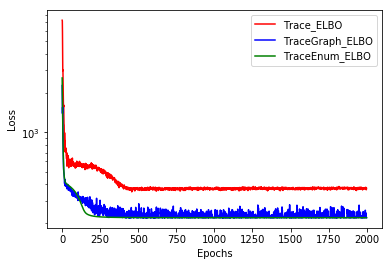

In [104]:
epoch_min=0
epoch_max=2000
plt.plot(losses_standard[epoch_min:epoch_max], '-',c='red',label='Trace_ELBO')
plt.plot(losses_sample[epoch_min:epoch_max], '-',c='blue',label='TraceGraph_ELBO')
plt.plot(losses_enum[epoch_min:epoch_max], '-',c='green',label='TraceEnum_ELBO')
plt.yscale('log')  
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='upper right')


print("locs standard vs sample vs enum ->",locs_standard,locs_sample,locs_enum)
print("scale sample vs enum ->",scale_standard,scale_sample,scale_enum)
print("(n0,n1) standard vs sample vs enum (%d %d) (%d %d) (%d %d)" % (n0_standard,n1_standard,n0_sample,n1_sample,n0_enum,n1_enum))

In [99]:
def compute_normal(x,mean,scale,n_particles):
    y = np.zeros_like(x)
    for i in range(y.shape[0]):
        tmp = np.sum(n_particles/(scale * np.sqrt(2 * np.pi)) * np.exp( - (x[i] - mean)**2 / (2 * scale**2) ))
        y[i] +=  tmp
    return y

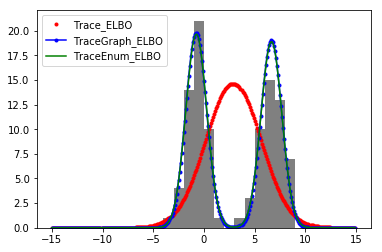

In [100]:
xmin=-15.0
xmax=15.0
dx=0.1

x = np.arange(xmin,xmax,dx)
y_standard = compute_normal(x,locs_standard.numpy(),scale_standard.numpy(),np.array([n0_standard,n1_standard]))
y_sample = compute_normal(x,locs_sample.numpy(),scale_sample.numpy(),np.array([n0_sample,n1_sample]))
y_enum = compute_normal(x,locs_enum.numpy(),scale_enum.numpy(),np.array([n0_enum,n1_enum]))

plt.hist(new_data, bins=30,range=(xmin,xmax),color='gray')
plt.plot(x,y_standard,".",c='red',label='Trace_ELBO')
plt.plot(x,y_sample,".-",c='blue',label='TraceGraph_ELBO')
plt.plot(x,y_enum,"-",c='green',label='TraceEnum_ELBO')
plt.legend(loc='upper left')